c:\Users\balikian\LocalData\CodesScripts\Github\wells4hydrogeology\w4h\core.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


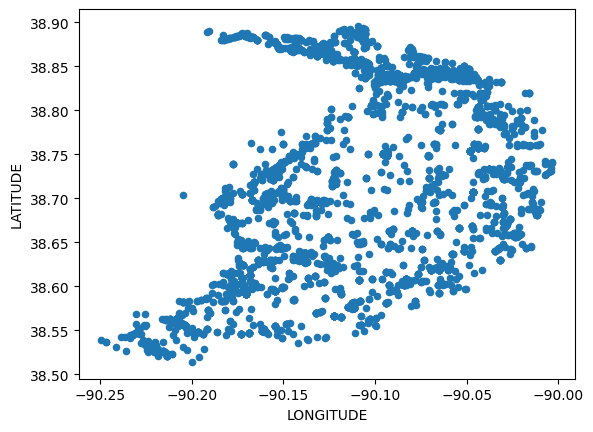

In [1]:
import w4h
import pandas as pd
resources = w4h.get_resources(scope='local')
study_area = resources['study_area']
df = resources['well_data']
df = pd.read_csv(df)
uniqueWellDF = df.drop_duplicates(subset='API_NUMBER')[["API_NUMBER", 'LATITUDE', "LONGITUDE", "ELEVATION"]].reset_index(drop=True)
uniqueWellDF.plot('LONGITUDE', "LATITUDE", kind='scatter')

import numpy as np
wellPtList = []
for i, well in uniqueWellDF.iterrows():
    wellPtList.append([well['LONGITUDE'], well["LATITUDE"]])
wellPtArr = np.array(wellPtList)

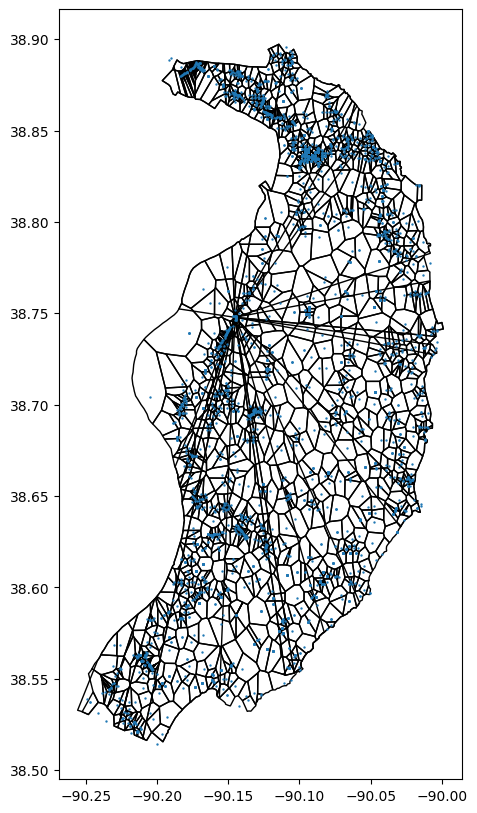

In [2]:
from shapely import Point, Polygon
import matplotlib.pyplot as plt
import geopandas as gpd
fig, ax = plt.subplots(figsize=(10,10))

from scipy.spatial import Voronoi
def natural_neighbor_interp(points, model_grid=None, layers=None, ):
    return Voronoi(points=points)
vClass = natural_neighbor_interp(wellPtArr)
dir(vClass)

geomList = []
verts = vClass.vertices
for region in vClass.regions:
    if len(region)>0:
        #region.append(region[0])

        currPoly = Polygon([verts[v] for v in region])
        if currPoly.is_valid:
            geomList.append(currPoly)

saCoords = Polygon([Point([-90.14341, 38.76749]), Point([-90.05592, 38.71129]), Point([-90.10095, 38.64567]), Point([-90.17643, 38.70627])])

sa = gpd.read_file(resources['study_area']).to_crs(4326)
test = gpd.GeoSeries(geomList, crs=4326)
test = test.clip(sa)
test.plot(edgecolor='k', ax=ax, facecolor="#00000000")
ax.scatter(x=uniqueWellDF['LONGITUDE'], y=uniqueWellDF['LATITUDE'], s=0.5)


c:\Users\balikian\LocalData\CodesScripts\Github\wells4hydrogeology\w4h\core.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


dict_keys(['LithologyDict_Exact', 'LithologyDict_Start', 'LithologyDict_Wildcard', 'LithInterps_FineCoarse', 'LithInterps_Clay', 'LithInterps_Silt', 'LithInterps_Sand', 'LithInterps_Gravel', 'well_data_dtypes', 'metadata_dtypes', 'ISWS_CRS', 'xyz_dtypes', 'model_grid', 'well_data', 'surf_elev', 'bedrock_elev', 'study_area'])


run
	Started at 2025-11-20 09:25:55.453451.
	Parameters:
		well_data=c:\Users\balikian\LocalData\CodesScripts\Github\wells4hydrogeology\w4h\resources\sample_data\statewide_sample_data\IL_Statewide_WellData_XYz_2023-07-20_cleaned.zip
		surf_elev_grid=c:\Users\balikian\LocalData\CodesScripts\Github\wells4hydrogeology\w4h\resources\sample_data\statewide_sample_data\IL_Statewide_Surface_Elev_ft_625ft_Lambert_GridAlign.tif
		bedrock_elev_grid=c:\Users\balikian\LocalData\CodesScripts\Github\wells4hydrogeology\w4h\resources\sample_data\statewide_sample_data\IL_Statewide_Bedrock_Elev_2023_ft_625ft_Lambert_GridAlign.tif
		model_grid=c:\Users\balikian\LocalData\CodesScript

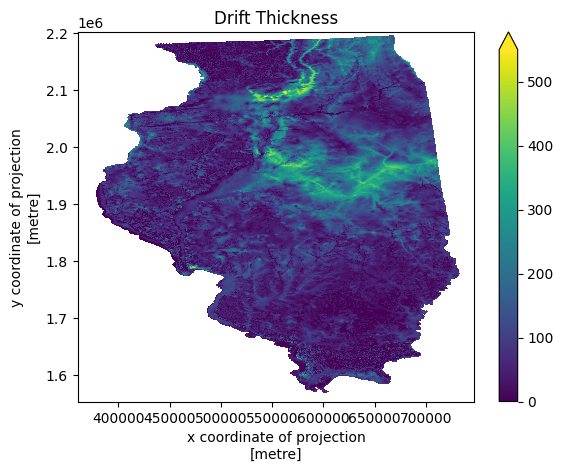

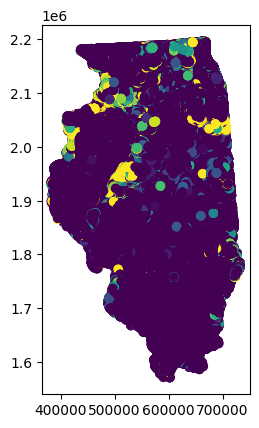

In [ ]:
import w4h

resources = w4h.get_resources(scope='state')
print(resources.keys())
outputs = w4h.run(well_data=resources['well_data'], 
                  surf_elev_grid=resources['surf_elev'],
                  bedrock_elev_grid=resources['bedrock_elev'],
                  model_grid=resources['model_grid'],
                  return_all=True,
                  verbose=True)

In [ ]:
w4h.plot_cross_section(outputs[1], profile=[profileA])

['NS', 'WE']
LINESTRING (610000 2180000, 625000 1850000)
1 NS
LINESTRING (455000 1950000, 700000 1900000)
1 WE


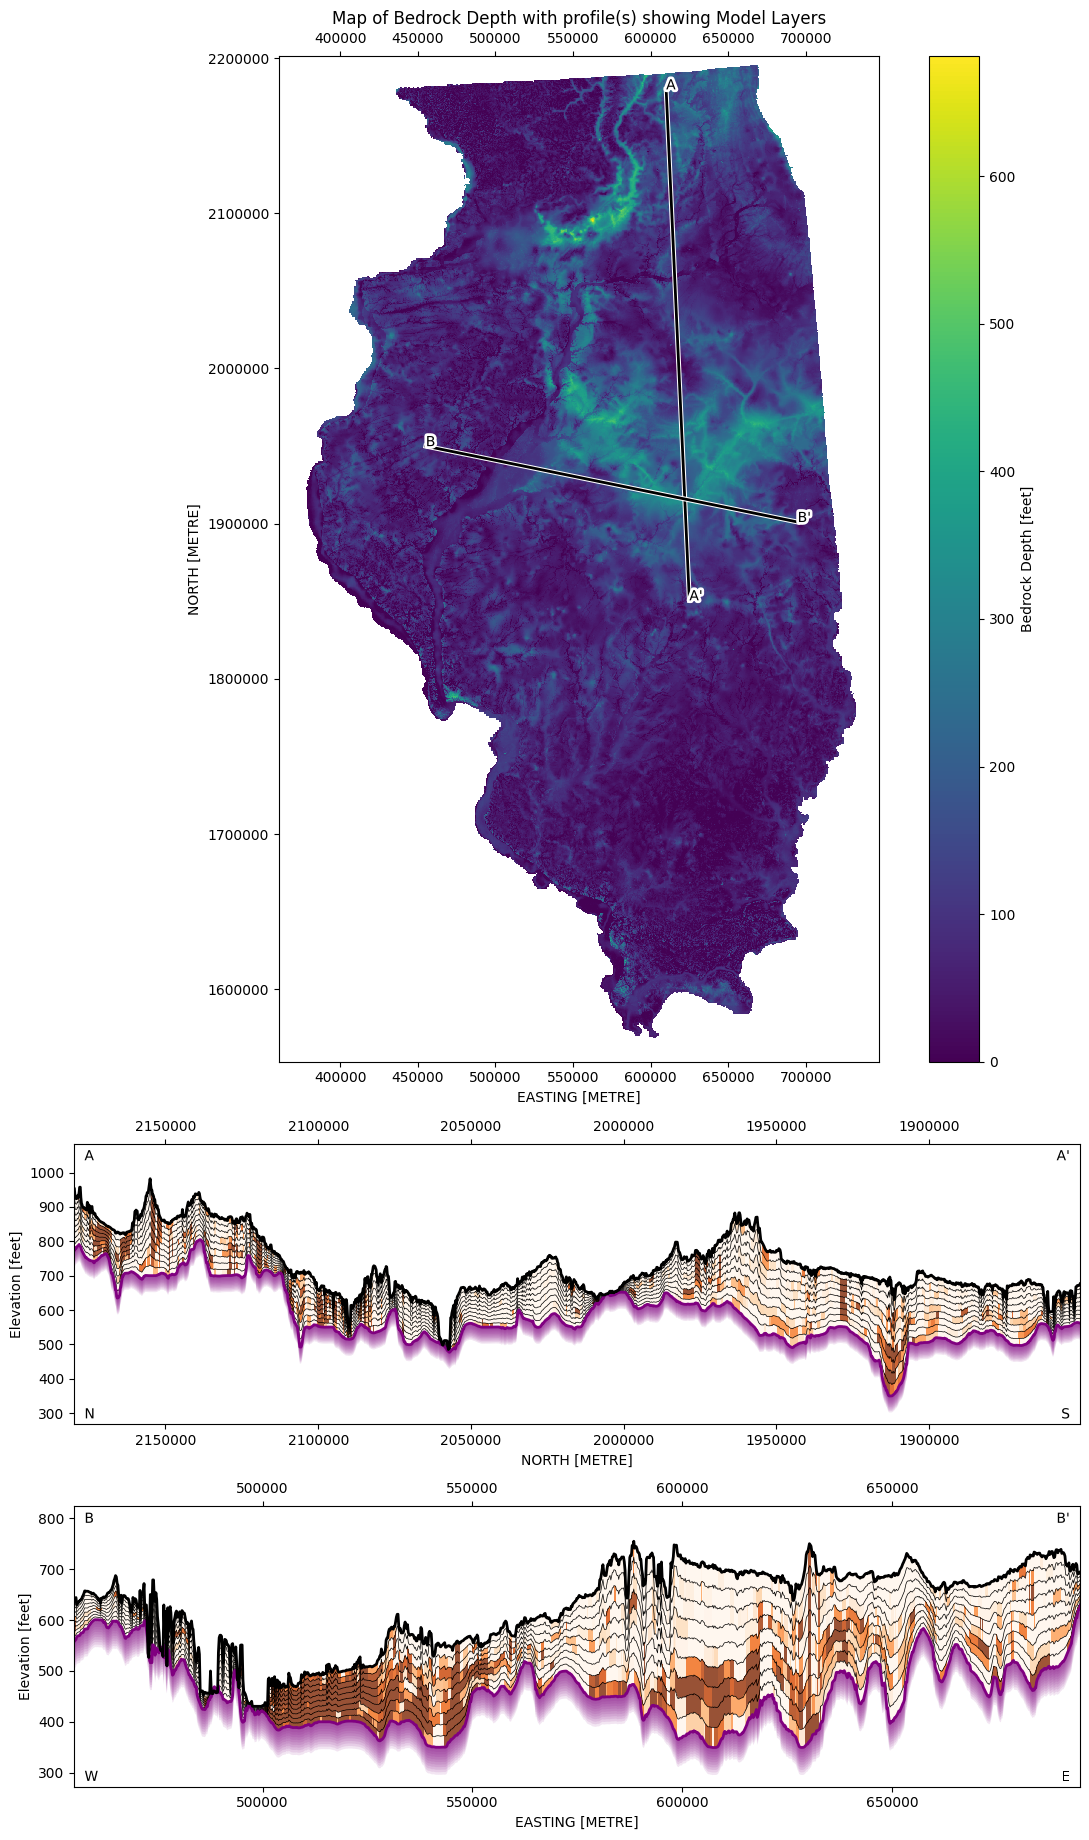

In [64]:
import warnings

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import pyproj
import shapely


def plot_cross_section(dataset, profile=None, profile_direction=None,
                       xcoord='x', ycoord='y',
                       mapped_variable='Bedrock_Depth',
                       cross_section_variable='Model_Layers',
                       surface_elevation_variable='Surface_Elevation',
                       bedrock_elevation_variable='Bedrock_Elevation',
                       layer_elevation_coordinate='layer_elevs',
                       show_layers=True, return_profile_dicts=False,
                       elev_unit='feet', convert_elevation_to=None,
                       title=None,
                       verbose=False, **kwargs):
    """Function to plot cross section profiles for datasets with properly configured coordinates and variables.
    This is intended to work "out of the box" with the xarray.Datasets output from w4h.run()

    Parameters
    ----------
    dataset : xarray.Dataset
        The xarray.Dataset with the proper data variables. Works "out of the box" with outputs from w4h.run().
    profile : None, shapely.Linestring, list of coordinates, or geopandas.GeoDataFrame, optional
        The profile(s) for which to create the cross sections.
        If None, by default creates one X profile and one Y profile in the middle of each dimension, by default None
    profile_direction : list of str, optional
        List of strings (list is same length as profile) indicating the direction to use for the profile. 
        If None, will be ['WE', 'SN'] to fit with profile=None defaults, by default None
    xcoord : str, optional
        Name of x coordinate, by default 'x'
    ycoord : str, optional
        Name of y coordinate, by default 'y'
    mapped_variable : str, optional
        Name of variable to show in main map, by default 'Depth_to_Bedrock'
    cross_section_variable : str, optional
        Name of variable to use for cross section profiles, by default 'Model_Layers'
    surface_elevation_variable : str, optional
        Variable to use for the surface elevation, by default 'Surface_Elevation'
    bedrock_elevation_variable : str, optional
        Variable to use for the bedrock elevation, by default 'Bedrock_Elevation'
    layer_elevation_coordinate : str, optional
        Coordinate name to use for the layer elevations. 
        This should be a non-indexed coordinate with the shape of the x, y, and layer coordinates, by default 'layer_elevs'
    show_layers : bool, optional
        Whether to plot the layer boundaries on the cross section, by default True
    return_profile_dicts : bool, optional
        Whether to return the profile dictionaries, rather than the matplotlib.Figure, by default False
    elev_unit : str, optional
        Unit of elevation for the elevation data, by default 'feet'
    convert_elevation_to : str, optional
        If None (default), does not convert elevation. Otherwise, will convert elevation to specified unit.
        Only conversion between 'ft' and 'meters' supported.
    title : str, optional
        Title to use for the output figure. If None, will be derived from variable names, by default None
    verbose : bool, optional
        Whether to print information about process to terminal, by default False

    Returns
    -------
    matplotlib.Figure
        Matplotlib.Figure instance is returned, unles return_profile_dicts is True.
        If return_profile_dicts=True, then a list of dicts with information about the profiles is returned.
    """
    
    # Get profile(s) into list format
    if profile is None:
        firstX = dataset.coords[xcoord].values[0]
        midX = np.mean(dataset.coords[xcoord].values)
        lastX = dataset.coords[xcoord].values[-1]

        firstY = dataset.coords[ycoord].values[0]
        midY = np.mean(dataset.coords[ycoord].values)
        lastY = dataset.coords[ycoord].values[-1]
        
        profileX = shapely.LineString([[firstX, midY], [lastX, midY]])
        profileY = shapely.LineString([[midX, firstY], [midX, lastY]])
        profile = [profileX, profileY]
        #profile_direction = ['WE', 'SN']
    elif isinstance(profile, gpd.GeoDataFrame):
        profile = profile.geometry.to_list()
    elif isinstance(profile, shapely.Geometry):
        profile = [profile]
    elif isinstance(profile, (list, tuple)):
        if not all(isinstance(item, (shapely.Geometry, gpd.GeoDataFrame)) for item in profile):
            print("If using a list or tuple for profile parameter, all items must be a shapely Geometry or geopandas GeoDataFrame")
            return
        newProfiles = profile.copy()
        for p in profile:
            if isinstance(p, gpd.GeoDataFrame):
                profileExt = p.geometry.to_list()
                newProfiles.extend(profileExt)
        profile = newProfiles
    else:
        print(f"\tThe profile parameter must shapely Geometry or geopandas GeoDataFrame or a list of those objects")
        return 
    
    # Figure out general direction of profile (longest axis)
    if profile_direction is None:
        profile_direction = []
        for p in profile:
            firstCoord = p.coords[0]
            lastCoord = p.coords[-1]
            xRange = abs(lastCoord[0] - firstCoord[0])
            yRange = abs(lastCoord[1] - firstCoord[1])
            
            if yRange > xRange:
                if lastCoord[1] > firstCoord[1]:
                    profile_direction.append("SN")
                else:
                    profile_direction.append("NS")
            else:
                if lastCoord[0] > firstCoord[0]:
                    profile_direction.append("WE")
                else:
                    profile_direction.append("EW")
    elif type(profile_direction)==str:
        profile_direction = [profile_direction]

    if verbose:
        print(profile_direction)

    if len(profile_direction) != len(profile):
        print(f"\tprofile and profile_direction must be the same length, but len(profile)={len(profile)} and len(profile_direction)={len(profile_direction)}")
        return

    # Get elevation in unit of interest
    if convert_elevation_to is not None:
        if elev_unit.lower() in ['feet', 'foot', 'ft', 'f']:
            if str(convert_elevation_to).lower() in ['meters', 'metres', 'meter', 'metre', 'mtr', 'm']:
                dataset[mapped_variable] = dataset[mapped_variable] * 0.3048
                dataset[surface_elevation_variable] = dataset[surface_elevation_variable] * 0.3048
                dataset[bedrock_elevation_variable] = dataset[bedrock_elevation_variable] * 0.3048
                dataset[layer_elevation_coordinate] = dataset[layer_elevation_coordinate] * 0.3048
                elev_unit = 'meters'
        elif elev_unit.lower() in ['meters', 'metres', 'meter', 'metre', 'mtr', 'm']:
            if str(convert_elevation_to).lower() in ['feet', 'foot', 'ft', 'f']:
                dataset[mapped_variable] = dataset[mapped_variable] * 3.2808399
                dataset[surface_elevation_variable] = dataset[surface_elevation_variable] * 3.2808399
                dataset[bedrock_elevation_variable] = dataset[bedrock_elevation_variable] * 3.2808399
                dataset[layer_elevation_coordinate] = dataset[layer_elevation_coordinate] * 3.2808399
                elev_unit = 'feet'

    profileDicts = []
    # Iterate through each profile
    for p_i, p in enumerate(profile):
        # Temporary lists for each segment/vertex
        segLengths = []
        segOrientations = []
        segSamplePoints = []
        surfaceElevs = []
        bedrockElevs = []
        layerElevs = []
        modelData = []
        
        print(p)
        # Iterate through each segment/vertex of the profile
        for i, vertex in enumerate(p.coords):
            if i == 0:
                continue
            prevVertex = p.coords[i-1]
            # Create accompanying component lists
            # For each segment...
            segmentLineString = shapely.LineString([prevVertex, vertex])
            
            # Get x and Y coordinates
            segXCoords = dataset.sel(x=slice(prevVertex[0], vertex[0])).coords['x'].values
            segYCoords = dataset.sel(y=slice(prevVertex[1], vertex[1])).coords['y'].values

            #print("SEG", i, segXCoords, segYCoords)

            # Get distance between each coordinate
            segXCoordsDists = np.diff(segXCoords)
            segYCoordsDists = np.diff(segYCoords)
            
            segLengths.append(segmentLineString.length)
            #print("SEGLEN", i, segLengths)

            # Get distance of each segment
            y1 = vertex[1]
            y0 = prevVertex[1]
            x1 = vertex[0]
            x0 = prevVertex[0]
            yDist = y1-y0
            xDist = x1-x0

            # Get orientation of segment
            segOrient='WE'
            if abs(yDist) > abs(xDist):
                segOrient = 'SN'
                if yDist < 0:
                    segOrient = 'NS'
            else:
                if xDist < 0:
                    segOrient = 'EW'
            segOrientations.append(segOrient)
            yOrients = ['NS', "SN", 'NORTH', 'SOUTH', 'N', 'S', 'LATITUDE', 'NORTHING', "SOUTHING"]
            xOrients = ['WE', "EW", 'EAST', 'WEST', 'E', 'W', "LONGITUDE", "EASTING", "WESTING"]

            # Get coordinates to sample for profile
            if segOrient.upper() in xOrients:
                vertexIndex = 0
                otherVertextInd = 1
                segCoords = segXCoords
                segCoordsDists = segXCoordsDists 

            else: # if oriented more NS
                vertexIndex = 1
                otherVertextInd = 0
                segCoords = segYCoords
                segCoordsDists = segYCoordsDists 

            print(i, segOrient)
            # For each segment, get each xy value as shapely point at each existing coordinate value
            subsegSamplePoints = []
            for i, segmentSegment in enumerate(segCoordsDists):
                currSubsegDistance = abs(np.sum(segCoordsDists[:i+1]))
                subsegSamplePoints.append(segmentLineString.line_interpolate_point(distance=currSubsegDistance))
            segSamplePoints.extend(subsegSamplePoints)

        profileLineString = shapely.LineString(segSamplePoints)
        for point in segSamplePoints:
            xcoord, ycoord = point.xy
            surfaceElevs.append(dataset[surface_elevation_variable].sel(x=xcoord, y=ycoord, method='nearest').values)
            bedrockElevs.append(dataset[bedrock_elevation_variable].sel(x=xcoord, y=ycoord, method='nearest').values)
            modelData.append(dataset[cross_section_variable].sel(x=xcoord, y=ycoord, method='nearest').values)
            layerElevs.append(dataset.coords[layer_elevation_coordinate].sel(x=xcoord, y=ycoord, method='nearest').values)
    
        surfElevArr = np.array(surfaceElevs).flatten()
        bedElevArr = np.array(bedrockElevs).flatten()

        profileDicts.append({'XY': shapely.LineString(segSamplePoints),
                             'Surface_Elevation': surfElevArr,
                             'Bedrock_Elevation': bedElevArr,
                             'xSection_Data': np.array(modelData).reshape((surfElevArr.shape[0], 9)),
                             'layer_elevs': np.array(layerElevs).reshape((surfElevArr.shape[0], 9)),
                             'profile_direction': profile_direction[p_i],
                             'elev_unit': elev_unit
                             })

    # Now just need to plot, already got data
    # Set up entire figure
    noSubplots = len(profileDicts)
    xSecSPList = []
    for letter in range(ord('A'), ord('A')+noSubplots):
        i = letter - ord('A')
        subplotName = 'XSEC'+chr(letter)
        profileDicts[i]['ProfileName'] = chr(letter)
        profileDicts[i]['SubplotName'] = subplotName

        xSecSPList.append([subplotName])

    subplotMosaicLists = [["MAP"],
                          ["MAP"],
                          ["MAP"]]
    subplotMosaicLists.extend(xSecSPList)

    # Get Figure/Axes sizing
    figH = 11
    figW = 17
    if len(subplotMosaicLists)<2:
        pass
    elif len(subplotMosaicLists) < 4:
        figH = 17
        figW = 11
    else:
        figW = 11
        figH = 11 + len(subplotMosaicLists) * 1.5
    plt.rcParams['figure.figsize'] = (figW, figH)
    fig, ax = plt.subplot_mosaic(subplotMosaicLists, layout='tight')

    if title is None:
        mVarTitle = mapped_variable.replace('_', ' ').title()
        xSecTitle = cross_section_variable.replace('_', ' ').title()
        titleStr = f'Map of {mVarTitle} with profile(s) showing {xSecTitle}'
    else:
        titleStr = title

    # Code to make map
    colorbar_kwargs = {'label': f"{mVarTitle} [{elev_unit}]"}
    dataset[mapped_variable].plot(ax=ax['MAP'],
                                cbar_kwargs=colorbar_kwargs)
    
    ax['MAP'].ticklabel_format(style='plain')
    ax['MAP'].set_aspect('equal')
    ax['MAP'].set_title(titleStr)

    proj = pyproj.CRS.from_user_input(dataset.spatial_ref.attrs['crs_wkt'])
    xUnit = 'Deg.'
    yUnit = 'Deg.'
    xName = 'Longitude'
    yName = 'Latitude'

    for a in proj.axis_info:
        if hasattr(a, 'direction'):
            if a.direction.upper() in xOrients:
                xUnit = str(a.unit_name)
                xName = str(a.name)
            else:
                yUnit = str(a.unit_name)
                yName = str(a.direction)

    xCoordLabel = f"{xName.upper()} [{xUnit.upper()}]"
    yCoordLabel = f"{yName.upper()} [{yUnit.upper()}]"
    ax['MAP'].set_xlabel(xCoordLabel)
    ax['MAP'].set_ylabel(yCoordLabel)

    # Code for plotting each profile
    for profile in profileDicts:
        # Set up plot
        currSubP = profile['SubplotName']
        plt.sca(ax[currSubP])

        plt.rcParams['xtick.top'] = True
        plt.rcParams["xtick.labeltop"] = True
        plt.rcParams["ytick.right"] = False
        plt.rcParams["ytick.labelright"] = False
        ax[currSubP].ticklabel_format(style='plain')

        xArray, yArray = profile["XY"].xy

        xArray = np.array(xArray.tolist())
        yArray = np.array(yArray.tolist())
        layer_elevs = profile['layer_elevs']
        xSection_Data = profile["xSection_Data"]
        br_elev = profile['Bedrock_Elevation']
        surf_elev = profile['Surface_Elevation']
        # Find rows in layer_elevs that contain any NaN values
        valid_rows = ~np.isnan(layer_elevs).any(axis=1)

        # Filter xArray, layer_elevs, and xSection_Data based on valid rows
        xArray_filtered = xArray[valid_rows]
        yArray_filtered = yArray[valid_rows]
        br_elevs_filtered = br_elev[valid_rows]
        surf_elevs_filtered = surf_elev[valid_rows]
        layer_elevs_filtered = layer_elevs[valid_rows, :]
        xSection_Data_filtered = xSection_Data[valid_rows, :]


        # Plot profile on map
        ax['MAP'].plot(xArray_filtered, yArray_filtered,
                       c='k', linewidth=2,#linestyle='dashed',
                       path_effects=[pe.withStroke(linewidth=3.5,
                                                   foreground="w")])
        
        # Add profile annotation
        ax['MAP'].text(xArray_filtered[0], yArray_filtered[0],
                       profile['ProfileName'],
                       path_effects=[pe.withStroke(linewidth=4, foreground="w")])
        
        ax['MAP'].text(xArray_filtered[-1], yArray_filtered[-1],
                       profile['ProfileName']+"'",
                       path_effects=[pe.withStroke(linewidth=4, foreground="w")])
        

        if profile['profile_direction'].upper() in xOrients:
            X = np.tile(xArray_filtered, (layer_elevs_filtered.shape[1], 1)).T
            coords = xArray_filtered
            coordLabel = xCoordLabel
        else:
            X = np.tile(yArray_filtered, (layer_elevs_filtered.shape[1], 1)).T
            coords = yArray_filtered
            coordLabel = yCoordLabel

        # Get Y values, have to be shifted up by 1/2 of layer thick to plot correctly
        Yfilter = layer_elevs_filtered
        Y = np.subtract(Yfilter, np.tile(np.nanmedian(np.diff(Yfilter, axis=-1), axis=-1)/2, (Yfilter.shape[1], 1)).T)

        if 'cmap' in kwargs:
            cMap = kwargs['cmap']
        elif 'colormap' in kwargs:
            cMap = kwargs['colormap']
        else:
            cMap = 'Oranges'

        # Plot data
        try:
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                pcm = ax[currSubP].pcolormesh(X, Y, xSection_Data_filtered, cmap=cMap, alpha=0.8)
            #fig.colorbar(pcm, ax=ax['MAP'])
        except Exception as e:
            print(f'colormesh didnt work: {e}')

        # Show model layers?
        if show_layers:
            ax[currSubP].plot(coords, layer_elevs_filtered,
                              c='k', linewidth=0.5)
            
        # Show cell divisions (vertical)?
        if len(coords) < 1000:
            ax[currSubP].vlines(coords,
                                ymin=br_elevs_filtered,
                                ymax=surf_elevs_filtered,
                                linewidths=0.25, colors='k')
            
        
        minBR = np.nanmin(br_elevs_filtered)
        maxSurf = np.nanmax(surf_elevs_filtered)
        
        stopVal = np.nanmax(np.subtract(surf_elev, br_elev))/(9/1.25)
        stepVal = stopVal//10
        ax[currSubP].fill_between(coords, br_elevs_filtered, br_elevs_filtered-(stopVal), facecolor='white', linewidth=2)
        for i in np.arange(0, stopVal, stepVal):
            ax[currSubP].fill_between(coords, br_elevs_filtered, br_elevs_filtered-(stopVal-i), facecolor='purple', linewidth=2, alpha=0.1)

        ax[currSubP].plot(coords, br_elevs_filtered, c='purple', linewidth=2)
        ax[currSubP].plot(coords, surf_elevs_filtered, c='k', linewidth=2)
        
        # Set y limits
        yRange = abs(maxSurf - (minBR-stopVal))
        yHi = maxSurf + (yRange * 0.15) # Need more space on top for annotation
        yLo = (minBR-stopVal) - (yRange * 0.05)
        ax[currSubP].set_ylim([yLo, yHi])
        ax[currSubP].set_xlim([coords[0], coords[-1]])

        # Annotate profile direction(s)
        ax[currSubP].annotate(text=profile['ProfileName'],
                              xy=(0.01, 0.98),
                              xycoords='axes fraction',
                              verticalalignment='top',
                              horizontalalignment='left',
                              path_effects=[pe.withStroke(linewidth=4,
                                                          foreground="w")])
        ax[currSubP].annotate(text=profile['profile_direction'][0],
                              xy=(0.01, 0.01),
                              xycoords='axes fraction',
                              verticalalignment='bottom',
                              horizontalalignment='left',
                              path_effects=[pe.withStroke(linewidth=4,
                                                          foreground="w")])
        
        
        ax[currSubP].annotate(text=profile['ProfileName']+"'",
                              xy=(0.99, 0.98),
                              xycoords='axes fraction',
                              verticalalignment='top',
                              horizontalalignment='right',
                              path_effects=[pe.withStroke(linewidth=4,
                                                          foreground="w")])
        ax[currSubP].annotate(text=profile['profile_direction'][1],
                              xy=(0.99, 0.01),
                              xycoords='axes fraction',
                              verticalalignment='bottom',
                              horizontalalignment='right',
                              path_effects=[pe.withStroke(linewidth=4,
                                                          foreground="w")])
        
        ax[currSubP].set_xlabel(coordLabel)
        ax[currSubP].set_ylabel(f"Elevation [{profile['elev_unit']}]")
        
    plt.tight_layout()
    plt.show()

    if return_profile_dicts:
        return profileDicts

    return fig

import shapely
profileA = shapely.LineString([[610000, 2180000], [625000, 1850000]])#,[575000, 1575000],[575000, 1575000]])
profileB = shapely.LineString([[455000, 1950000], [700000, 1900000]])

mapFig = plot_cross_section(dataset=outputs[1], profile=[profileA, profileB], verbose=True)

In [54]:
outputs[1].variables

Frozen({'x': <xarray.IndexVariable 'x' (x: 2010)> Size: 16kB
array([360524.698254, 360717.052709, 360909.407163, ..., 746580.088331,
       746772.442786, 746964.79724 ], shape=(2010,))
Attributes:
    axis:           X
    long_name:      x coordinate of projection
    standard_name:  projection_x_coordinate
    units:          metre, 'y': <xarray.IndexVariable 'y' (y: 3368)> Size: 27kB
array([2201175.426627, 2200983.072173, 2200790.717718, ..., 1553902.68741 ,
       1553710.332956, 1553517.978501], shape=(3368,))
Attributes:
    axis:           Y
    long_name:      y coordinate of projection
    standard_name:  projection_y_coordinate
    units:          metre, 'Layer': <xarray.IndexVariable 'Layer' (Layer: 9)> Size: 72B
array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'Model_Layers': <xarray.Variable (Layer: 9, y: 3368, x: 2010)> Size: 487MB
array([[[0.474, 0.474, 0.474, ..., 0.   , 0.   , 0.   ],
        [0.474, 0.474, 0.474, ..., 0.   , 0.   , 0.   ],
        [0.474, 0.474, 0.474, ..., 0.   

In [24]:
outputs[1].to_netcdf(r"C:\Users\balikian\OneDrive - University of Illinois - Urbana\Data_OneDrive\Wells\9-Layer Hydrogeo Model\statewide_sample_run_2025-11-19.nc")

In [30]:
for tables in range(9):
    outputs[0][tables].to_csv(f"C:/Users/balikian/OneDrive - University of Illinois - Urbana/Data_OneDrive/Wells/9-Layer Hydrogeo Model/outputSampleCSVs/LYR_{tables}_StatewideSampleRun_2025-11-19.csv")

In [ ]:
import pyproj
pyproj.CRS.from_wkt(outputs[1].spatial_ref.crs_wkt)

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [23]:
import rioxarray as rxr
outputs[1].rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)
outputs[1].rio.write_grid_mapping(inplace=True)
outputs[1].rio.write_crs(pyproj.CRS.from_wkt(outputs[1].spatial_ref.crs_wkt), inplace=True)

<xarray.Dataset> Size: 839MB
Dimensions:            (x: 2010, y: 3368, Layer: 9)
Coordinates:
  * x                  (x) float64 16kB 3.605e+05 3.607e+05 ... 7.47e+05
  * y                  (y) float64 27kB 2.201e+06 2.201e+06 ... 1.554e+06
  * Layer              (Layer) int64 72B 1 2 3 4 5 6 7 8 9
    layer_elevs        (Layer, y, x) float32 244MB nan nan nan ... nan nan nan
    spatial_ref        int64 8B 0
Data variables:
    Model_Layers       (Layer, y, x) float64 487MB 0.474 0.474 0.474 ... 0.0 0.0
    Surface_Elevation  (y, x) float32 27MB nan nan nan nan ... nan nan nan nan
    Bedrock_Elevation  (y, x) float32 27MB nan nan nan nan ... nan nan nan nan
    Bedrock_Depth      (y, x) float32 27MB nan nan nan nan ... nan nan nan nan
    Layer_Thickness    (y, x) float32 27MB nan nan nan nan ... nan nan nan nan

In [54]:
from sqlalchemy import create_engine
import pandas as pd

server = "datastorm.prairie.illinois.edu"
database = "GEOPROD"
driver = "ODBC Driver 17 for SQL Server" # Adjust based on your installed driver version
connection_url = f"mssql+pyodbc://@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
engine = create_engine(connection_url)

df = pd.read_sql_table(table_name='Borehole_Locations', con=engine, schema='ISGS2')
print(df.head())

        API10  SECTION  TWP TDIR  RNG RDIR  MERIDIAN  NSFOOT NSDIR  EWFOOT  \
0  1200100002     12.0  1.0    N  5.0    W       4.0  1572.0     S   578.0   
1  1200100003     12.0  1.0    N  5.0    W       4.0     0.0     S     0.0   
2  1200100004     20.0  1.0    N  5.0    W       4.0     NaN  None     NaN   
3  1200100005     22.0  1.0    N  5.0    W       4.0     NaN  None     NaN   
4  1200100006     24.0  1.0    N  5.0    W       4.0   200.0     N   200.0   

   ... VLC FIPS_CODE  TWN_CODE RNG_CODE  SEC_CODE  PLOT  ENTERED_DATE  \
0  ... NaN       001       01N      05W        12  None           NaT   
1  ... NaN       001       01N      05W        12  None           NaT   
2  ... NaN       001       01N      05W        20  None           NaT   
3  ... NaN       001       01N      05W        22  None           NaT   
4  ... NaN       001       01N      05W        24  None           NaT   

   ENTERED_BY         UPDATE_DATE UPDATE_BY  
0         AXS 2003-02-19 16:33:46      None  


In [ ]:
wellDF = pd.read_sql_table(table_name='downhole_data', con=engine, schema='ISGS2')
print(df.head())

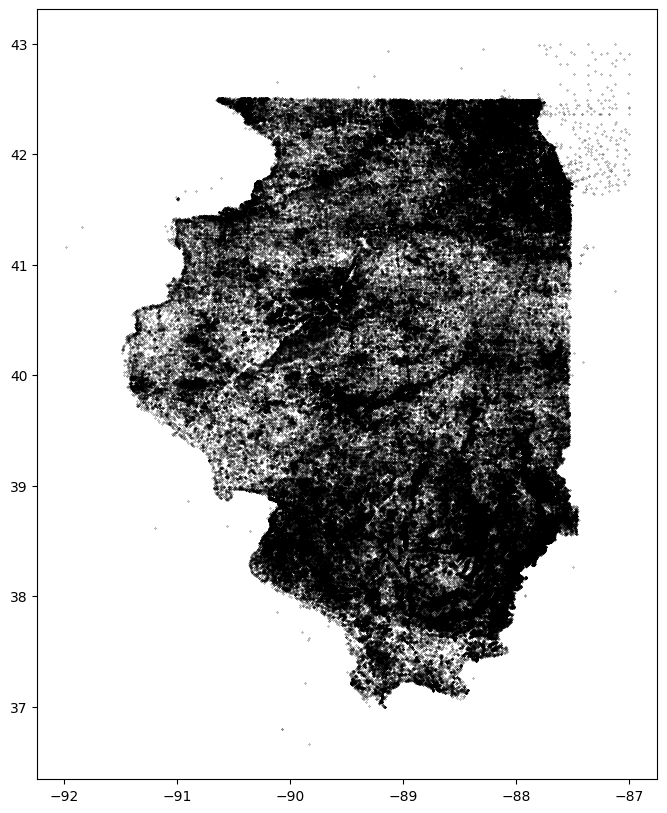

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,10))
ax.scatter(df['LONGITUDE'], df['LATITUDE'], s=0.05, c='k')

In [1]:
import w4h
import spacy
import pandas as pd

df = pd.read_csv(w4h.get_resources(scope='statewide')['well_data'])
df
df = df.sort_values(by=['API_NUMBER', 'TOP']).reset_index(drop=True).drop(columns='ID')
smallDF = df.head(10000)
smallDF
df

c:\Users\balikian\LocalData\CodesScripts\Github\wells4hydrogeology\w4h\core.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


,API_NUMBER,FORMATION,TOP,BOTTOM,ELEVATION,LATITUDE,LONGITUDE
0,120010000300,interval drift?,0.0,18.0,590.0,40.079858,-90.913587
1,120010000300,"Colchester No. 2 coal,Penn. carb",18.0,20.0,590.0,40.079858,-90.913587
2,120010000300,fire clay at,20.0,20.0,590.0,40.079858,-90.913587
3,120010000800,interval,0.0,175.0,0.0,40.039934,-90.923914
4,120010000800,coal No. 2 possibly at,175.0,175.0,0.0,40.039934,-90.923914
...,...,...,...,...,...,...,...
2249833,480590043000,sand silt & gravel,6.0,171.0,825.0,42.496858,-88.095136
2249834,480590043000,yellow clay,18.0,18.0,825.0,42.496858,-88.095136
2249835,480590043000,"sandy blue clay, soft",35.0,120.0,825.0,42.496858,-88.095136
2249836,480590043000,"red clay, firm",45.0,165.0,825.0,42.496858,-88.095136


In [39]:
import numpy as np
dfSample = df.iloc[np.r_[11:14, 141:144, 181:184, 227:230]]
dfSample

,API_NUMBER,FORMATION,TOP,BOTTOM,ELEVATION,LATITUDE,LONGITUDE
11,120010001100,clay & coal,0.0,37.0,730.0,40.029328,-90.962715
12,120010001100,"limestone, nodular",37.0,39.0,730.0,40.029328,-90.962715
13,120010001100,clay & soapstone,39.0,51.0,730.0,40.029328,-90.962715
141,120010002900,"si,cly,slgt s(f),noncalc,ox,rd-brn",0.0,3.0,644.0,39.879224,-90.933490
142,120010002900,"si,cly,f s,noncalc,ox,rd-brn",3.0,5.0,644.0,39.879224,-90.933490
143,120010002900,"si,cly,slgt s(f),noncalc,ox,rd-brn",5.0,8.0,644.0,39.879224,-90.933490
181,120010003400,"drift (clay,yellow clay,blue)",0.0,30.0,691.0,40.107100,-91.095902
182,120010003400,"sandstone,red",30.0,80.0,691.0,40.107100,-91.095902
183,120010003400,"soapstone,light gray",80.0,87.0,691.0,40.107100,-91.095902
227,120010005200,Glacial Drift,13.0,33.0,759.0,39.772902,-90.938585


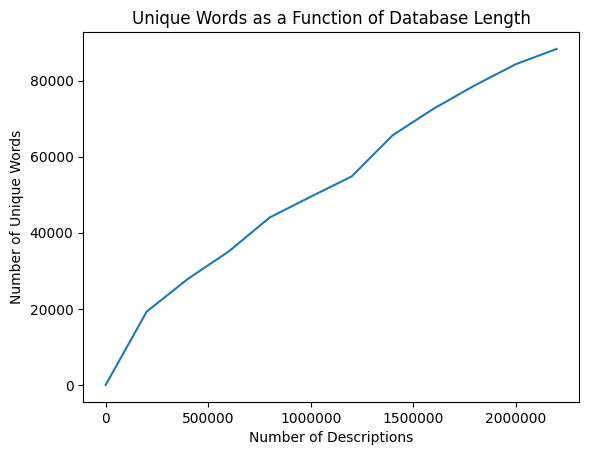

In [8]:
dfLengths = []
numUniqueWords = []
maxLength = df.shape[0]
step = 200000
for i in range(0, maxLength, step):
    dfLengths.append(i)
    smallDF = df.head(i)
    
    wordList = []
    sentenceList = []
    for i, row in smallDF.iterrows():
        sentenceList.extend(str(row['FORMATION']).replace(',', ' ').replace(';', ' ').replace('.', ' ').split())
    numUniqueWords.append(len(set(sentenceList)))
    
import matplotlib.pyplot as plt

fix, ax = plt.subplots()
ax.plot(dfLengths, numUniqueWords)
ax.ticklabel_format(useOffset=False, style='plain')
plt.title("Unique Words as a Function of Database Length")
plt.xlabel("Number of Descriptions")
plt.ylabel("Number of Unique Words")
plt.show()

In [3]:
def preprocess_nlp(df, description_col="FORMATION",
                   nlp_model_size='small',
                   remove_puncuation=True, **kwargs):

    nlpSmallList = ['small', 's']
    nlpMedList = ['medium', 'med', 'md', 'm']
    nlpLargeList = ['large', 'lg', 'l']
    nlpTransList = ['transformer', 'trans', 'tr', 't']

    replace_str = ""
    if remove_puncuation:
        replace_str = r"[^\w\s]"
        
    df.loc[:, f"PREPROCESSED_{description_col}"] = df.loc[:,description_col].str.lower().str.replace(replace_str, '')
    

    return df

dfPre = preprocess_nlp(smallDF)
dfPre

C:\Users\balikian\AppData\Local\Temp\ipykernel_44496\10182315.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, f"PREPROCESSED_{description_col}"] = df.loc[:,description_col].str.lower().str.replace(replace_str, '')


,ID,API_NUMBER,TABLE_NAME,WHO,INTERPRET_DATE,FORMATION,THICKNESS,TOP,BOTTOM,ID.1,LATITUDE,LONGITUDE,ELEVATION,geometry,PREPROCESSED_FORMATION
0,0,1.216330e+11,WFORMATIONS,NaN,NaN,clay & silty clay,15.0,0.0,15.0,377397,38.520278,-90.218333,396.538940,POINT (-90.218333 38.520278),clay & silty clay
1,1,1.216330e+11,WFORMATIONS,NaN,NaN,sand,96.0,15.0,111.0,377397,38.520278,-90.218333,396.538940,POINT (-90.218333 38.520278),sand
2,2,1.216330e+11,WFORMATIONS,NaN,NaN,crushed rock,3.0,0.0,3.0,376978,38.520917,-90.213611,410.760956,POINT (-90.213611 38.520917),crushed rock
3,3,1.216330e+11,WFORMATIONS,NaN,NaN,clay,4.0,3.0,7.0,378246,38.520917,-90.213611,410.760956,POINT (-90.213611 38.520917),clay
4,4,1.216330e+11,WFORMATIONS,NaN,NaN,brown & gray sand,9.0,18.0,27.0,376978,38.520917,-90.213611,410.760956,POINT (-90.213611 38.520917),brown & gray sand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,1.216331e+11,WFORMATIONS,NaN,NaN,lean silt/silty s mst brn fine grained,8.0,0.0,8.0,327131,38.556400,-90.204478,405.462738,POINT (-90.204478 38.5564),lean silt/silty s mst brn fine grained
996,996,1.216331e+11,WFORMATIONS,NaN,NaN,prly grdd s silty s gry f-med grained,8.0,42.0,50.0,327131,38.556400,-90.204478,405.462738,POINT (-90.204478 38.5564),prly grdd s silty s gry f-med grained
997,997,1.216331e+11,WFORMATIONS,NaN,NaN,prly grdd s w/ silt gry f-med grained,37.0,50.0,87.0,327131,38.556400,-90.204478,405.462738,POINT (-90.204478 38.5564),prly grdd s w/ silt gry f-med grained
998,998,1.216331e+11,WFORMATIONS,NaN,NaN,prly grdd s/lean c brn f-med grained,24.0,8.0,32.0,327131,38.556400,-90.204478,405.462738,POINT (-90.204478 38.5564),prly grdd s/lean c brn f-med grained


In [24]:
testStr = "TEST ONE     TWO THREE"
testStr.split()

['TEST', 'ONE', 'TWO', 'THREE']

537

In [4]:

import re
import string

# From: https://pypi.org/project/fkscore/
class fkscore:
    """ Flesch Kincaid Readability Score
    text = "The quick red fox jumped over the lazy brown dog."
    stats:
     sentences = 1
     words = 10
     syllables = 12
    score
     readability = 86.705
     read_grade = 6th Grade
     calc_grade =
    """

    def __init__(self, text):
        """
        Input: UTF-8 text as str

        Output (stats):
            stats['num_words']
            stats['num_syllables']
            stats['num_sentences']
        Output (score):
            score['readability']  # Calculated F-K Readability
            score['read_grade']   # Permuted F-K Grade Reading Level
        """
        self.stats = {}
        self.basic_stats(text)
        self.score = {}
        self.fk_score()
        self.permute_grade()
        self.calc_grade()

    def basic_stats(self, rawtext):
        # Primary text segregation function
        output = {'sentences': 0, 'words': 0, 'wordblock': [], 'errors': []}

        # Split on \n or . ! ? for sentences
        wip_text = re.split(r'''(\n|(\.+|!+|\?+) +)''', rawtext)

        # Split Sentences (keep punctuation)
        for i, s in enumerate(wip_text):
            try:
                if s is not None and len(s.strip()) > 1 and i < len(wip_text):
                    try:
                        punctuation = wip_text[i + 1]
                    except Exception:
                        punctuation = ''
                    sentence_text = (wip_text[i] + punctuation).replace('\n', '')
                    output['sentences'] += 1

                    translator = str.maketrans('', '', string.punctuation)
                    words = sentence_text.translate(translator).split(' ')
                    output['words'] += len(words)
                    wordblock = output['wordblock'] + words
                    output['wordblock'] = [x for x in wordblock if x != '' and x is not None]
            except Exception as exc:
                output['error'].append(exc)

        self.stats['num_sentences'] = output['sentences']
        self.stats['num_words'] = output['words']

        # Syllable computation
        def num_syllables(word):
            word = word.lower()
            count = 0
            vowels = "aeiouy"
            if word[0] in vowels:
                count += 1
            for index in range(1, len(word)):
                if word[index] in vowels and word[index - 1] not in vowels:
                    count += 1
            if word.endswith("e"):
                count -= 1
            if count == 0:
                count += 1
            return count

        self.stats['num_syllables'] = sum([num_syllables(x) for x in output['wordblock']])

    def fk_score(self):
        # Flesch Reading Ease Score (FRE)
        self.score['readability'] = round(206.835 -
                                          (1.015 * (self.stats['num_words'] / self.stats['num_sentences'])) -
                                          (84.6 * (self.stats['num_syllables'] / self.stats['num_words'])), 3)

    def permute_grade(self):
        # FRE read_grade level
        self.score['read_grade'] = '4th Grade or Below'
        if round(self.score['readability'], 0) >= 90:
            self.score['read_grade'] = '5th Grade'
        elif round(self.score['readability'], 0) >= 80:
            self.score['read_grade'] = '6th Grade'
        elif round(self.score['readability'], 0) >= 70:
            self.score['read_grade'] = '7th Grade'
        elif round(self.score['readability'], 0) >= 60:
            self.score['read_grade'] = '9th Grade'
        elif round(self.score['readability'], 0) >= 50:
            self.score['read_grade'] = '11th Grade'
        elif round(self.score['readability'], 0) >= 30:
            self.score['read_grade'] = 'College Level'
        else:
            self.score['read_grade'] = 'College Graduate'

    def calc_grade(self):
        # Calculated grade level
        self.score['calc_grade'] = round((0.39 * (self.stats['num_words'] / self.stats['num_sentences'])) +
                                         (11.8 * (self.stats['num_syllables'] / self.stats['num_words']))
                                         - 15.59, 3)

testFK = fkscore("I am jumping very high")
testFK.stats


{'num_sentences': 1, 'num_words': 5, 'num_syllables': 7}

In [ ]:
import spacy

nlp = spacy.load("en_core_web_trf")
print("ROOT        | WORDS | CHARS | SYLLABLES | FK READABILITY | FK GRADELVL |    CHUNK    | TEXT")
print('----------------------------------------------------------------------------------------------')
for i, interval in dfPre.iterrows():
    doc_description = nlp(interval['PREPROCESSED_FORMATION'])

    if i < 250 and i > 100:
        sentCharLength = len(doc_description.text.strip())
        fkS = fkscore(interval['PREPROCESSED_FORMATION'])
        fkReadability = fkS.score['readability']
        fkCalcGrade = fkS.score['calc_grade']
        fkWords = fkS.stats['num_words']
        fkSyllables = fkS.stats['num_syllables']
        
        dfList = []
        for token in doc_description:
            dfList.append([token.text, token.pos_, token.dep_, token.is_oov])
            if token.dep_ == 'ROOT':
                rootStr = str.ljust(token.text, 10)
        
        chunkText = ''
        for chunk in doc_description.noun_chunks:
            #if len(str(chunk))>13:
            #    chunk=str(chunk)[:13]
            chunkText += str(chunk)+' :: '
        
        print(f' {rootStr} |  {str.center(str(fkWords), 3)}  | {str.center(str(sentCharLength), 3)}   | {str.center(str(fkSyllables), 9)} |   {str.center(str(fkReadability), 13)}  | {str.center(str(fkCalcGrade), 10)}  | {str.center(chunkText, 50)}                   | {doc_description.text.strip()}')
        #print(pd.DataFrame(dfList, columns=['Text', "P.O. Speech", "Dependency Relationship", "Out of Vocab."]).set_index('Text'))
        
        
    elif i>250:
        break

#from spacy.lang.en.examples import sentences 

#doc = nlp(sentences[0])
#print(doc.text)
#for token in doc:
#    print(token.text, token.pos_, token.dep_, token.ent_id_)

ROOT        | WORDS | CHARS | SYLLABLES | FK READABILITY | FK GRADELVL |    CHUNK    | TEXT
----------------------------------------------------------------------------------------------
 gry        |   9   |  40   |     11    |        94.3      |   2.342     |    vy crs sand gry :: .5" gravel :: cobbles ::                       | vy crs sand gry w/ .5" gravel w/ cobbles
 sand       |   1   |  4    |     1     |       121.22     |    -3.4     |                      sand ::                                         | sand
 clay       |   4   |  17   |     4     |      118.175     |   -2.23     |               clay :: silty clay ::                                  | clay & silty clay
 rock       |   2   |  8    |     2     |      120.205     |   -3.01     |                    red rock ::                                       | red rock
 sand       |   3   |  13   |     3     |       119.19     |   -2.62     |                 sand :: gravel ::                                    | sand & gra